# 4.4 模型选择、欠拟合和过拟合

In [4]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用的数据集生成：

$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon 
$$

$$
\text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).
$$

In [5]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [6]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.0551],
         [0.4625]]),
 tensor([[1.0000e+00, 5.5080e-02, 1.5169e-03, 2.7851e-05, 3.8351e-07, 4.2248e-09,
          3.8784e-11, 3.0518e-13, 2.1012e-15, 1.2859e-17, 7.0829e-20, 3.5466e-22,
          1.6279e-24, 6.8974e-27, 2.7137e-29, 9.9646e-32, 3.4303e-34, 1.1114e-36,
          3.4010e-39, 9.8595e-42],
         [1.0000e+00, 4.6254e-01, 1.0697e-01, 1.6493e-02, 1.9072e-03, 1.7643e-04,
          1.3601e-05, 8.9873e-07, 5.1962e-08, 2.6705e-09, 1.2352e-10, 5.1941e-12,
          2.0021e-13, 7.1234e-15, 2.3535e-16, 7.2572e-18, 2.0980e-19, 5.7083e-21,
          1.4668e-22, 3.5709e-24]]),
 tensor([5.0351, 5.3552]))

In [7]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9939485  1.1944052 -3.415902   5.6148896]]


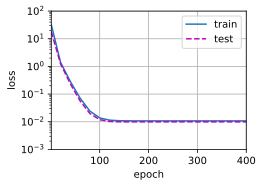

In [8]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.654454 4.905688]]


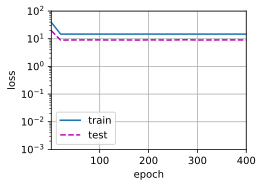

In [9]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.971333    1.293536   -3.3458896   5.1889935  -0.19747029  0.8721186
   0.09968839 -0.05315391 -0.0234624  -0.02888253 -0.11058248  0.04622987
   0.02157308  0.10724127  0.14596525  0.11291102 -0.11674512  0.20397076
  -0.03012781 -0.08491039]]


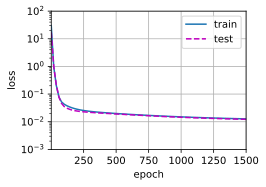

In [10]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## 练习题

练习题 1：这个多项式回归问题可以准确地解出吗？提示：使用线性代数

练习题 2：考虑多项式的模型选择

* 绘制训练损失与模型复杂度（多项式的阶数）的关系图。观察到了什么？需要多少阶的多项式才能将训练损失减少到 0？
* 在这种情况下绘制测试的损失图
* 生成同样的图，作为数据量的函数

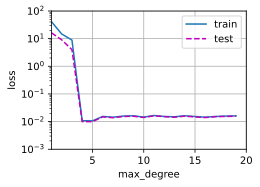

In [ ]:
def train1(train_features, test_features, train_labels, test_labels,
          num_epochs=1001):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
    return (evaluate_loss(net, train_iter, loss),
                                         evaluate_loss(net, test_iter, loss))


animator = d2l.Animator(xlabel='max_degree', ylabel='loss', yscale='log',
                            xlim=[1, max_degree], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
for degree in range(1,20):
    animator.add(degree, train1(poly_features[:n_train, :degree], poly_features[n_train:, :degree],
      labels[:n_train], labels[n_train:]))        

练习题 3：如果不对多项式特征 $x^i$ 进行标准化（$1/i!$），会发生什么事情？能用其他方法解决这个问题吗

是为了避免带来过大的指数值从而使梯度或损失值过大

可以考虑取对数

练习题 4：泛化误差可能为零吗

泛化误差为零意味着模型可以完全预测未见过的数据，理论上可以为零，但在实际情况中很难出现这样的情况。